### 仮説
#### 訪日外国人の観光客と商用客の来日割合は顕著に変動し、観光シーズンおよびビジネスシーズンが区別できる

### 訪日外国人の観光客と商用客の来日割合は顕著に変動し、観光シーズンおよびビジネスシーズンが区別できる

#### データベースからデータの取得
Webスクレイピングによりデータを取得し、仮説の検証に必要なデータをdbへ格納した。
データの構造が見やすいようにcsvファイルで一度必要なデータを保存している。

In [34]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import sqlite3


# WebサイトのURL
url = 'https://www.tourism.jp/tourism-database/stats/inbound/'

# Webページの内容を取得
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Excelシートのダウンロードリンクを動的に取得
excel_links = soup.find_all('a', href=lambda href: href and 'inbound' in href and href.endswith('.xlsx'))

# リンクが見つからない場合の処理
if not excel_links:
    raise Exception('エクセルファイルのダウンロードリンクが見つかりません')

# 取得したリンクを表示し、確認
for link in excel_links:
    print(f'Found Excel link: {link["href"]}')

# 正しいリンクパターンを考慮して条件付け
correct_link_start = "https://www.tourism.jp/wp/wp-content/uploads/"

# 最初のリンクを選択し、URLを修正
for link in excel_links:
    excel_url = link['href']
    if excel_url.startswith("/wp/wp-content/uploads/"):
        excel_url = f"https://www.tourism.jp{excel_url}"
        break

print(f'Downloading from: {excel_url}')

# エクセルファイルをダウンロード
excel_response = requests.get(excel_url)

# 応答ヘッダーを確認する
print(f'Content-Type: {excel_response.headers.get("Content-Type")}')  # MIMEタイプをプリント

# 応答が正常かどうかを確認
if excel_response.status_code == 200:
    # ダウンロードされたデータの一部を確認する
    print(excel_response.content[:100])  # 最初の100バイトをプリント

    # finprj フォルダー内にファイルを保存
    download_dir = 'finprj'
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # ファイル名を動的に取得する例。リンクの末尾をファイル名として取得
    file_name = os.path.basename(excel_url)
    file_path = os.path.join(download_dir, file_name)

    with open(file_path, 'wb') as file:
        file.write(excel_response.content)

    print(f'エクセルファイルを {file_path} にダウンロードしました。')
    
    custom_column_names = ['月', '入国総数', '観光客', '商用客']
    # pandasを使ってダウンロードしたExcelファイルを読み込む
    try:
        # 特定のシートを指定する
        df = pd.read_excel(file_path, sheet_name='国別・目的別（アジア）', engine='openpyxl',
                           usecols="B:E",     # 読み込む列
                           nrows=60,          # 読み込む行数
                           skiprows=231,      # スキップする行数
                           header=None,
                           names=custom_column_names
                           ) 

        # 読み込んだデータフレームの最初の数行を表示
        print(df.head(10))  # 最初の10行を表示
        print("読み込まれたデータフレームの全体の形状:", df.shape)

        # Excelファイルの構造を確認するためにデータフレームの情報を表示
        print("データフレームの構造:")
        print(df.info())

        # データをそのままCSVファイルとして保存する
        output_csv_path = os.path.join(download_dir, 'output.csv')
        df.to_csv(output_csv_path, index=False, encoding='utf-8')
        
        print(f'データが {output_csv_path} に保存されました。')
        
    except Exception as e:
        print(f'Excelファイルの読み込みに失敗しました: {e}')
else:
    print(f'The status code was: {excel_response.status_code}')
    print('The response content was:')
    print(excel_response.text)


# svcファイルを修正して新しいCSVファイルを作成
# 読み込みファイルパスを指定
input_file = 'finprj/output.csv'  # 正しいパスに修正
output_file = 'finprj/revise.csv'  # 保存先も同じディレクトリに修正

# CSVファイルを読み込む
df = pd.read_csv(input_file)

# 「月」列を「年」と「月」に分ける関数を定義
def split_year_month(value):
    # 年が含まれている場合とそうでない場合を処理
    if '年' in value:
        parts = value.split('年')
        year = parts[0].strip()
        month = int(parts[1].strip('月').strip())
    else:
        year = None
        month = int(value.strip('月').strip())
    
    return year, month

# 新しいデータフレームを作成
new_rows = []
current_year = None

for index, row in df.iterrows():
    year, month = split_year_month(row['月'])
    if year:
        current_year = year
    elif current_year:
        year = current_year
    
    new_row = {
        '年': int(year),
        '月': month,
        '入国総数': row['入国総数'],
        '観光客': row['観光客'],
        '商用客': row['商用客']
    }
    new_rows.append(new_row)

# 新しいデータフレームを作成
new_df = pd.DataFrame(new_rows)

# CSVファイルに書き出し
new_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("新しいCSVファイルが作成されました。")
print("新しいデータフレームの最初の数行:")
print(new_df.head(10))  # 最初の10行を表示

# データベースにデータを保存
# CSVファイルのパス
csv_file = 'finprj/revise.csv'
db_file = 'finprj/visitors.db'

# CSVファイルを読み込む
df = pd.read_csv(csv_file)

# SQLiteデータベースに接続（存在しない場合は作成される）
conn = sqlite3.connect(db_file)

# データフレームをSQLiteデータベースに格納
df.to_sql('visitors', conn, if_exists='replace', index=False)

# データベース接続を閉じる
conn.close()

print(f"データが {db_file} に格納されました。")

db_file = 'finprj/visitors.db'
if os.path.exists(db_file):
    if os.access(db_file, os.R_OK) and os.access(db_file, os.W_OK):
        print(f'{db_file} is readable and writable.')
    else:
        print(f'{db_file} is not accessible.')

# SQLiteデータベースに接続
try:
    conn = sqlite3.connect(db_file)
    print("Database connection successful")
    
    # クエリを実行してデータを取得
    query = "SELECT * FROM visitors"
    df = pd.read_sql_query(query, conn)
    
    # データの確認
    print("Data in 'visitors' table:")
    print(df.head(60))  # データベースの最初の60行を表示

except sqlite3.OperationalError as e:
    print("OperationalError occurred while connecting to the database or fetching data:", e)
except Exception as e:
    print("Error occurred:", e)
finally:
    if 'conn' in locals():  # connが定義されている場合のみ閉じる
        conn.close()
        print("Database connection closed")

Found Excel link: /wp/wp-content/uploads/2025/01/JTM_inbound_20241226.xlsx
Content-Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00:\xf0\xcb\xab\x8b\x01\x00\x00\x1c\x07\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
エクセルファイルを finprj/JTM_inbound_20241226.xlsx にダウンロードしました。
           月     入国総数      観光客     商用客
0  2015年　　1月  1018348   845575   80858
1       　　2月  1200651  1076219   69649
2         3月  1243295  1030970   94570
3         4月  1463927  1289815   91232
4         5月  1384930  1222377   91173
5         6月  1363207  1221664   89089
6         7月  1620334  1471641   89740
7         8月  1570066  1401069   77690
8         9月  1362193  1168504   86075
9        10月  1527602  1343297  103267
読み込まれたデータフレームの全体の形状: (60, 4)
デー

#### データ分析
最初に、年別に観光客と商用客の来日割合を計算した。
次に、訪日外国人の総数、観光客数、商用客数がどのように変化しているのかを視覚的にわかりやすく知るため、棒グラフを作成した。
棒グラフについては、縦軸が割合、横軸が年、青が観光客、オレンジが商用客、緑が総数を表している。

Database connection successful
年別の観光客と商用客の割合:
         観光客割合     商用客割合
年                       
2015  0.881171  0.063659
2016  0.893531  0.054515
2017  0.902374  0.047825
2018  0.903836  0.044557
2019  0.897484  0.042970


/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtoo

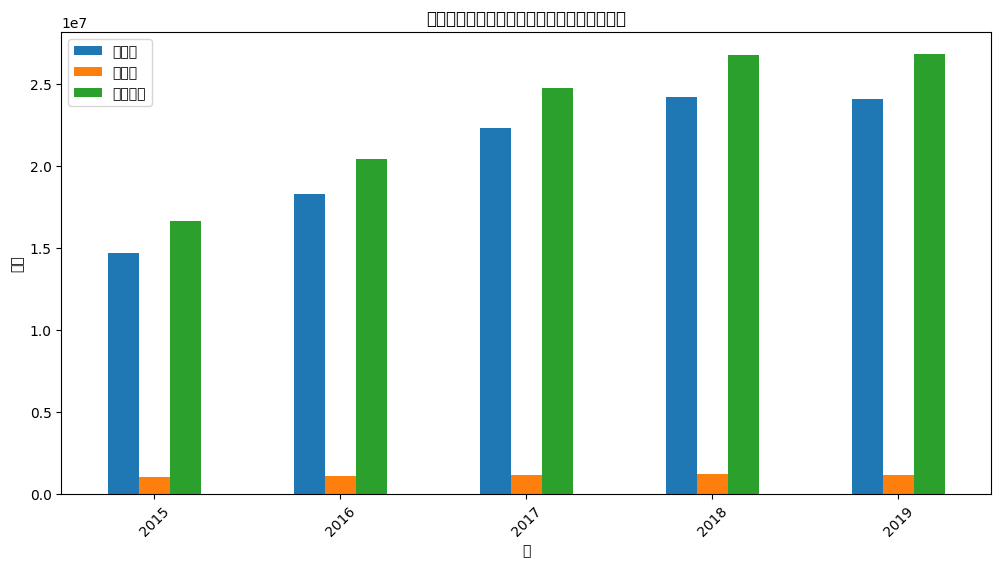

Database connection closed


In [35]:
import matplotlib.pyplot as plt

# SQLiteデータベースに接続
db_file = 'finprj/visitors.db'
try:
    conn = sqlite3.connect(db_file)
    print("Database connection successful")
    
    # クエリを実行してデータを取得
    query = "SELECT * FROM visitors"
    df = pd.read_sql_query(query, conn)

    # 年別に集計
    yearly_data = df.groupby('年').sum()

    # 年別の観光客と商用客の割合を計算
    yearly_data['観光客割合'] = yearly_data['観光客'] / yearly_data['入国総数']
    yearly_data['商用客割合'] = yearly_data['商用客'] / yearly_data['入国総数']

    # 年別の観光客と商用客の割合を表示
    print("年別の観光客と商用客の割合:")
    print(yearly_data[['観光客割合', '商用客割合']])

    # 年別の訪日外国人観光客、商用客、入国総数の比較棒グラフを作成
    ax = yearly_data[['観光客', '商用客', '入国総数']].plot(kind='bar', figsize=(12, 6))
    ax.set_title('年別の訪日外国人観光客、商用客、入国総数')
    ax.set_xlabel('年')
    ax.set_ylabel('人数')
    plt.xticks(rotation=45)
    plt.show()

except sqlite3.OperationalError as e:
    print("OperationalError occurred while connecting to the database or fetching data:", e)
except Exception as e:
    print("Error occurred:", e)
finally:
    if 'conn' in locals():  # connが定義されている場合のみ閉じる
        conn.close()
        print("Database connection closed")

一年の中で、観光客の割合と商用客の割合はどのように変化しているのかを折れ線グラフであらわした。
割合に顕著な変化があるのか、ないのかを一目で確認でき、仮説の検証が可能となる。
折れ線グラフにおいて、縦軸が割合、横軸が月、青が観光客、オレンジが商用客である。

Database connection successful


/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:17

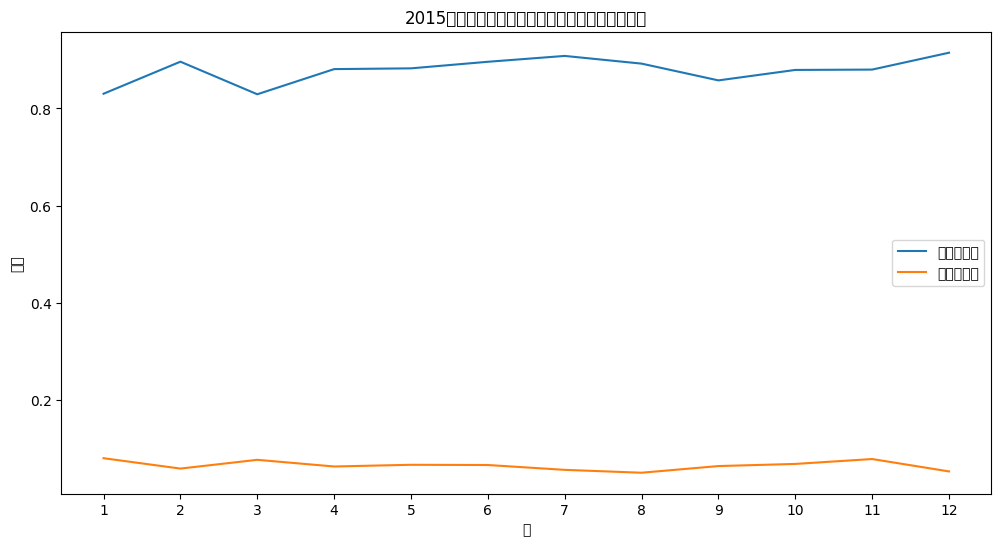

/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:17

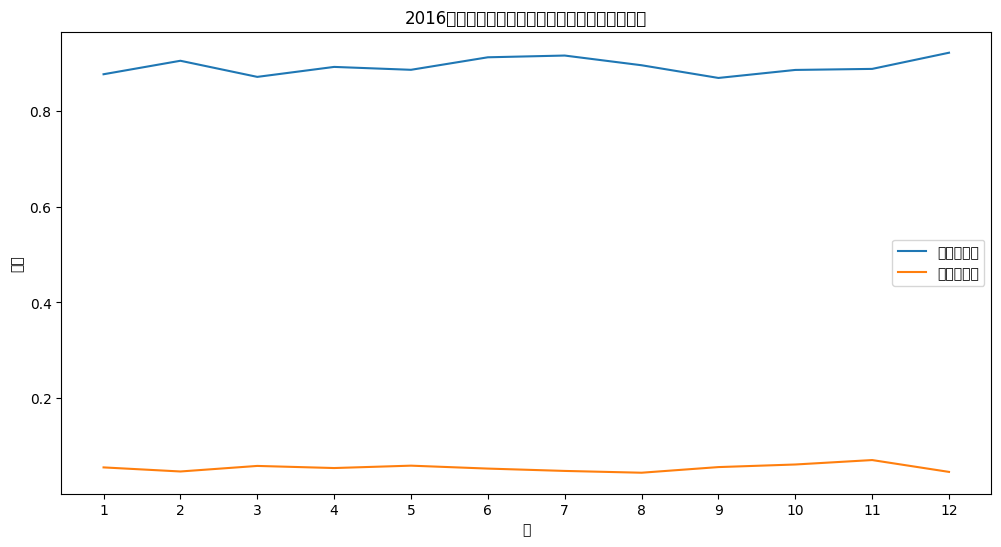

/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:17

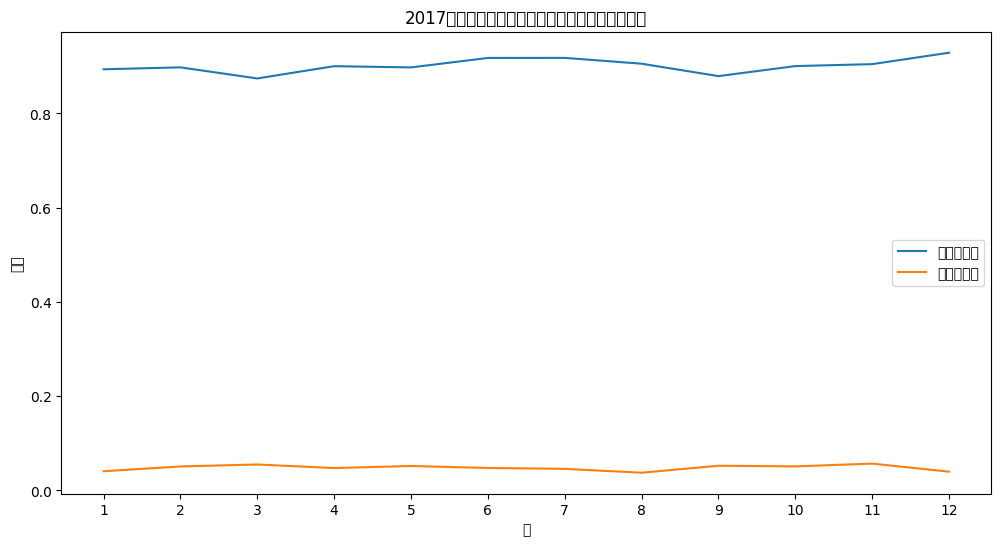

/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21106 (\N{CJK UNIFIED IDEOGRAPH-5272}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wakana/dsprog2/local/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:17

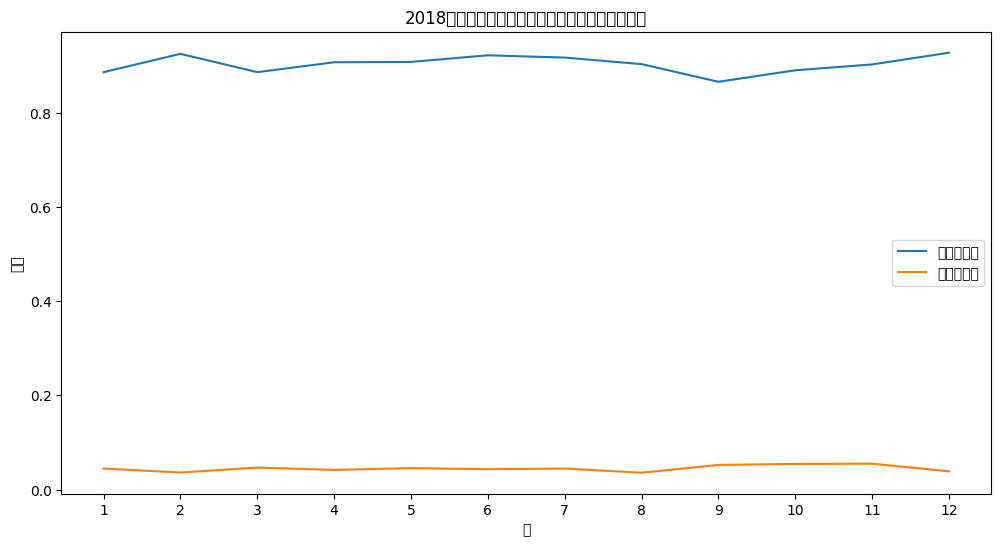

Database connection closed


In [36]:
def plot_monthly_changes(year):
    # 特定の年のデータをフィルタ
    yearly_df = df[df['年'] == year].copy()
    
    # 月ごとの観光客と商用客の割合を計算
    yearly_df['観光客割合'] = yearly_df['観光客'] / yearly_df['入国総数']
    yearly_df['商用客割合'] = yearly_df['商用客'] / yearly_df['入国総数']
    
    # 月をインデックスとして設定
    yearly_df.set_index('月', inplace=True)
    
    # 折れ線グラフを作成
    ax = yearly_df[['観光客割合', '商用客割合']].plot(kind='line', figsize=(12, 6))
    ax.set_title(f'{year}年の月ごとの観光客割合と商用客割合の変化')
    ax.set_xlabel('月')
    ax.set_ylabel('割合')
    plt.xticks(range(1, 13))
    plt.show()

try:
    conn = sqlite3.connect(db_file)
    print("Database connection successful")
    
    # クエリを実行してデータを取得
    query = "SELECT * FROM visitors"
    df = pd.read_sql_query(query, conn)

    # 各年ごとに月ごとの割合変化をプロット
    plot_monthly_changes(2015)
    plot_monthly_changes(2016)
    plot_monthly_changes(2017)
    plot_monthly_changes(2018)

except sqlite3.OperationalError as e:
    print("OperationalError occurred while connecting to the database or fetching data:", e)
except Exception as e:
    print("Error occurred:", e)
finally:
    if 'conn' in locals():  # connが定義されている場合のみ閉じる
        conn.close()
        print("Database connection closed")